$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# A2 Adam vs SGD

Daniel Kielman
dwkielman@gmail.com

## Overview

The purpose of this assignment is to compare the results when predciting using the one-hidden layer neural network and then train the neural networks in two ways: one with SGD and one with Adam.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

Let's create a long vector of all of the weights in both layers.  Then we can define the weight matrix for each layer as views into this vector.  This allows us to take steps down the gradient of the error function by incrementing the whole weight vector.

Spend a little time understanding the difference between numpy views and copies.  [Here is a good tutorial](http://www.jessicayung.com/numpy-views-vs-copies-avoiding-costly-mistakes/).

In [2]:
def make_weights(shapes):
    '''make_weights(shape): weights is list of pairs of (n_inputs, n_units) for each layer.
    n_inputs includes the constant 1 input.
    Returns weight vector w of all weights, and list of matrix views into w for each layer'''
    # Make list of number of weights in each layer
    n_weights_each_matrix = [sh[0] * sh[1] for sh in shapes]
    # Total number of weights
    n_weights = sum(n_weights_each_matrix)
    # Allocate weight vector with component for each weight
    w = np.zeros(n_weights)
    # List Ws will be list of weight matrix views into w for each layer
    w_views = make_views_on_weights(w, shapes)
    return w, w_views    

In [3]:
def make_views_on_weights(w, shapes):    
    w_views = []
    first = 0
    for sh in shapes:
        # Create new view of w[first:last]
        last = first + sh[0] * sh[1]
        # Create new view of w[first:last] as matrix W to be matrix for a layer
        W = w[first:last].reshape(sh)
        # Initialize weight values to small uniformly-distributed values
        n_inputs = sh[0]
        scale = 1.0 / np.sqrt(n_inputs)
        W[:] = np.random.uniform(-scale, scale, size=sh)
        # Add to list of W matrices, Ws.
        w_views.append(W)
        first = last
    return w_views

In [4]:
# Set parameters of neural network
nHiddens = 10
nOutputs = 1

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
Vshape = (1 +1, nHiddens)
Wshape = (nHiddens + 1, nOutputs)
w, [V, W] = make_weights([Vshape, Wshape])

print('w\n', w)
print('V\n', V)
print('W\n', W)

w
 [-0.68581022 -0.51813869 -0.26327713  0.64356669  0.28425909  0.69864971
 -0.31076423 -0.12853121 -0.30384686 -0.22567614 -0.44605411  0.46456064
  0.43790662 -0.64977194  0.22571226 -0.14293796 -0.22721028  0.37239708
 -0.33952511  0.54897994 -0.15071938  0.06724993  0.05605135  0.12830748
  0.00125066 -0.00603149 -0.1059098  -0.13548719 -0.15825539  0.04782536
  0.11310623]
V
 [[-0.68581022 -0.51813869 -0.26327713  0.64356669  0.28425909  0.69864971
  -0.31076423 -0.12853121 -0.30384686 -0.22567614]
 [-0.44605411  0.46456064  0.43790662 -0.64977194  0.22571226 -0.14293796
  -0.22721028  0.37239708 -0.33952511  0.54897994]]
W
 [[-0.15071938]
 [ 0.06724993]
 [ 0.05605135]
 [ 0.12830748]
 [ 0.00125066]
 [-0.00603149]
 [-0.1059098 ]
 [-0.13548719]
 [-0.15825539]
 [ 0.04782536]
 [ 0.11310623]]


Now for some functions for calculating the output of our network, and for backpropagating the error to get a gradient of error with respect to all weights.

In [5]:
def forward(w_views, X1):
    # Forward pass on training data
    V, W = w_views
    Z = np.tanh(X1 @ V)
    Z1 = np.insert(Z, 0, 1, 1)
    Y = Z1 @ W
    return Z1, Y

In [6]:
def backward(w_views, X1, Z1, T, error):
    V, W = w_views
    # Backward pass. 
    # Calculate the gradient of squared error with respect to all weights in w.
    #   Order of in w is all hidden layer weights followed by all output layer weights,
    #   so gradient values are ordered this way.
    gradient =  np.hstack(((- X1.T @ ( ( error @ W[1:, :].T) * (1 - Z1[:, 1:]**2))).flat,  # for hidden layer
                          (- Z1.T @ error).flat))  # for output layer
    return gradient

Given these functions, we can now define the stochastic gradient descent, `sgd`, procedure to update the weights.

In [7]:
def sgd_init():
    pass

def sgd(w, w_views, X1, T, learning_rate):
    Z1, Y = forward(w_views, X1)

    # Error in output
    n_samples = X1.shape[0]
    n_outputs = T.shape[1]
    
    error = (T - Y) / (n_samples + n_outputs)

    gradient = backward(w_views, X1, Z1, T, error)
   
    # update values of w, in place. Don't need to return it.
    
    w -= learning_rate * gradient

Here is another way to update the weights, the `adam` procedure.  See [this discussion](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) of Adam and other gradient descent methods.

In [8]:
grad_trace = 0
grad_squared_trace = 0
update_step = 0

def adam_init():
    global grad_trace, grad_squared_trace, update_step

    grad_trace = 0
    grad_squared_trace = 0
    update_step = 0
    
def adam(w, w_views, X1, T, learning_rate):
    global grad_trace, grad_squared_trace, update_step

    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    Z1, Y = forward(w_views, X1)

    # Error in output
    error = T - Y

    gradient = backward(w_views, X1, Z1, T, error)
    
    # approximate first and second moment
    grad_trace = beta1 * grad_trace + (1 - beta1) * gradient
    grad_squared_trace = beta2 * grad_squared_trace + (1 - beta2) * np.square(gradient)
    
    # bias corrected moment estimates
    grad_hat = grad_trace / (1 - beta1 ** (update_step + 1) )
    grad_squared_hat = grad_squared_trace / (1 - beta2 ** (update_step + 1) )
                
    dw = grad_hat / (np.sqrt(grad_squared_hat) + epsilon)
    
    n_samples = X1.shape[0]
    n_outputs = T.shape[1]
    
    # update values of w, in place. Don't need to return it.
    w -= learning_rate / (n_samples + n_outputs) * dw
    
    update_step += 1

Now, wrap these all together into a function to train a neural network given the training and testing data, the gradient descent function names, the batch size, the number of epochs, the learning rate, and the graphics update rate.

In [9]:
def train(Xtrain, Ttrain, Xtest, Ttest,
          n_hiddens, 
          gradient_descent_method_init, gradient_descent_method, 
          batch_size, n_epochs, learning_rate, graphics_rate=0):

    if graphics_rate > 0 and Xtrain.shape[1] > 1:
        print('Graphics only works when X has one column (data has one input variable)')
        print('Setting graphics_rate to 0')
        graphics_rate = 0
    
    # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]
    Vshape = (1 + n_inputs, n_hiddens)
    Wshape = (1 + n_hiddens, n_outputs)
    w, [V, W] = make_weights([Vshape, Wshape])

    error_trace = np.zeros((n_epochs, 2))

    if graphics_rate > 0:
        fig = plt.figure(figsize=(12, 10))
        
    Xtrain1 = np.insert(Xtrain, 0, 1, 1)
    Xtest1 = np.insert(Xtest, 0, 1, 1)
    n_samples = Xtrain1.shape[0]
        
    gradient_descent_method_init()
    
    for epoch in range(n_epochs):

        # gradient_descent_method_init()
        
        # Reorder samples
        rows = np.arange(n_samples)
        np.random.shuffle(rows)
        
        for first_n in range(0, n_samples, batch_size):
            last_n = first_n + batch_size
            rows_batch = rows[first_n:last_n]
            Xtrain1_batch = Xtrain1[rows_batch, :]
            Ttrain_batch = Ttrain[rows_batch, :]
            # gradient_descent method changes values of w
            gradient_descent_method(w, [V, W], Xtrain1_batch, Ttrain_batch, learning_rate)
    
        # error traces for plotting
        Z1train, Ytrain = forward([V, W], Xtrain1)
        error_trace[epoch, 0] = np.sqrt(np.mean(((Ttrain - Ytrain)**2)))
    
        Z1test, Ytest = forward([V, W], Xtest1)
        error_trace[epoch, 1] = np.sqrt(np.mean((Ytest - Ttest)**2))

        if graphics_rate > 0 and (epoch % graphics_rate == 0 or epoch == n_epochs - 1):
            plt.clf()
            plt.subplot(3, 1, 1)
            plt.plot(error_trace[:epoch, :])
            plt.ylim(0, 0.4)
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.legend(('Train','Test'), loc='upper left')
        
            plt.subplot(3, 1, 2)
            plt.plot(Xtrain, Ttrain, 'o-', Xtest, Ttest, 'o-', Xtrain, Ytrain, 'o-')
            plt.xlim(-1, 1)
            plt.ylim(-0.2, 1.6)
            plt.legend(('Training', 'Testing', 'Model'), loc='upper left')
            plt.xlabel('$x$')
            plt.ylabel('Actual and Predicted $f(x)$')
        
            plt.subplot(3, 1, 3)
            plt.plot(Xtrain, Z1train[:, 1:])  # Don't plot the constant 1 column
            plt.ylim(-1.1, 1.1)
            plt.xlabel('$x$')
            plt.ylabel('Hidden Unit Outputs ($z$)');
        
            ipd.clear_output(wait=True)
            ipd.display(fig)

    ipd.clear_output(wait=True)

    return Ytrain, Ytest, error_trace

Here are some demonstrations.

In [10]:
# Make some training data
n = 20
Xtrain = np.linspace(0.,20.0,n).reshape((n,1)) - 10
Ttrain = 0.2 + 0.05 * (Xtrain + 10) + 0.4 * np.sin(Xtrain + 10) + 0.2 * np.sin(Xtrain * 3) + 0.01 * np.random.normal(size=(n, 1))
Xtrain = Xtrain / 10

# Make some testing data
n = n // 3
Xtest = np.linspace(0, 20, n).reshape((-1, 1)) - 10
Ttest = 0.2 + 0.05 * (Xtest + 10) + 0.2 * np.sin(Xtest + 10) +  0.1 * np.sin(Xtest * 3) + 0.01 * np.random.normal(size=(n, 1))
Xtest = Xtest / 10

Final RMSE 0.133411176946


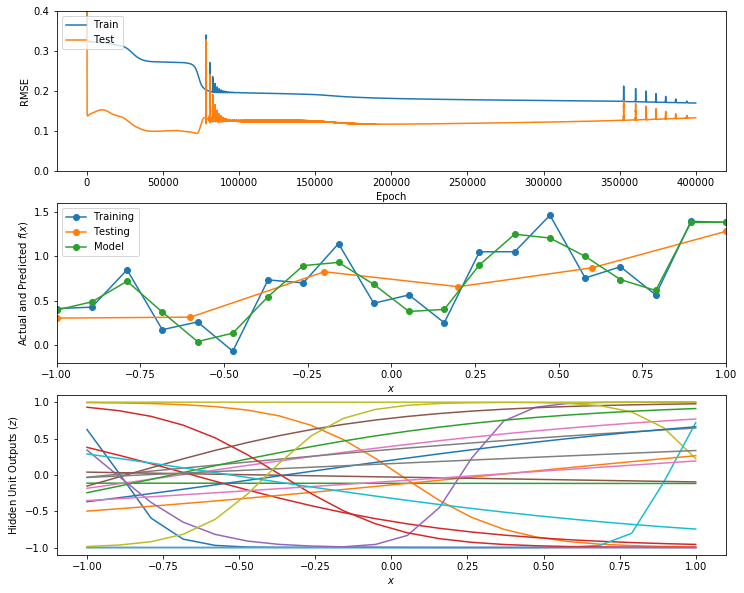

In [11]:
Ytrain, Ytest, error_trace = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=sgd_init, gradient_descent_method=sgd,
                       batch_size=Xtrain.shape[0], n_epochs=400000, learning_rate=0.2, graphics_rate=10000)
print('Final RMSE', np.sqrt(np.mean((Ttest - Ytest)**2)))

Final RMSE 0.314023828538


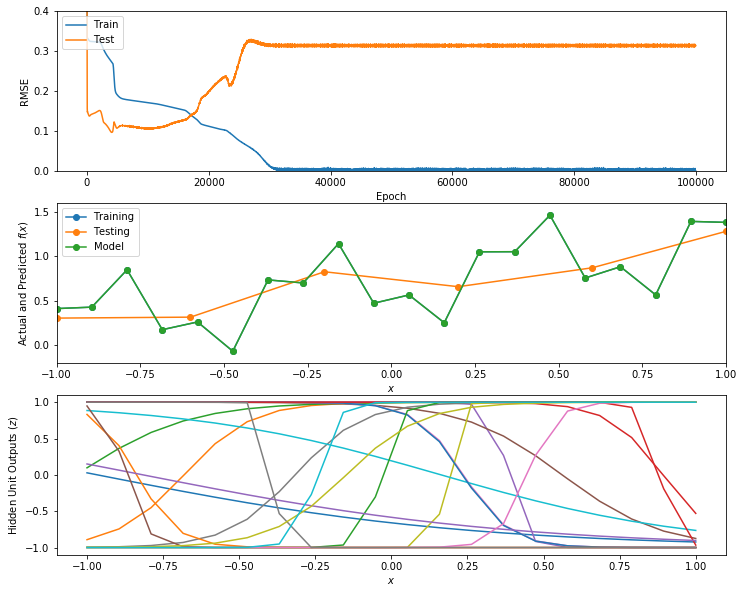

In [12]:
Ytrain, Ytest, error_trace = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=adam_init, gradient_descent_method=adam,
                       batch_size=Xtrain.shape[0], n_epochs=100000, learning_rate=0.05, graphics_rate=5000)
print('Final RMSE', np.sqrt(np.mean((Ttest - Ytest)**2)))

SGD 0.13837906458 Adam 0.126982707952


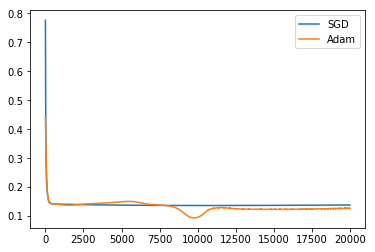

In [13]:
n_samples = Xtrain.shape[0]

_, _, error_trace_adam = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=adam_init, gradient_descent_method=adam,
                       batch_size=n_samples, n_epochs=20000, learning_rate=0.01, graphics_rate=0)

_, _, error_trace_sgd = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=sgd_init, gradient_descent_method=sgd,
                       batch_size=n_samples, n_epochs=20000, learning_rate=0.01, graphics_rate=0)

plt.plot(np.hstack((error_trace_sgd[:, 1:], error_trace_adam[:, 1:])))
plt.legend(('SGD', 'Adam'))

print('SGD', error_trace_sgd[-1, 1], 'Adam', error_trace_adam[-1, 1])

# Search for Good Parameter Values on a New Data Set

Now your work begins.  First, download this [Real Estate Valuation Data](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set) from the UCI machine learning repository. Read it in to python and form an input matrix `X` that contains six columns, and target matrix `T` of one column containing the house price of unit area.  This is easiest to do with the [pandas](https://pandas.pydata.org/) package.  Check out the [Getting Started](http://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html) material at the pandas site.  Near the bottom of that page are some simple examples of how to use the `read_excel` pandas function.  Pretty handy since the Real Estate data is an `.xlsx` file.  Other helpful functions are the `drop` function that can be used to remove a column, such as the one labeled `No` in the data file, which is just an index that we should ignore, and `data.columns.tolist()` where `data` is a Dataframe.  Also note that a Dataframe can be converted to a `numpy` array by `npdata = np.array(data)` where `data` again is a Dataframe.

We want to try to predict the target value from the six input values.

Randomly partition the data into an 80% partition for training, making `Xtrain` and `Ttrain`, and a 20% partition for testing, makng `Xtest` and `Ttest`.

Standardize the input `Xtrain` and `Xtest` matrices by subtracting by the column means and dividing by the column standard deviations, with the means and standard deviations determined only from the `Xtrain` matrix.

Using the one-hidden layer neural network implemented here, train neural networks in two ways: one with SGD and one with Adam.  For each, try at least three values for each of the following parameters:

  * number of hidden units, from 1 to 50,
  * batch size,
  * number of epochs
  * learning_rate

Create a table of results containing the algorithm name ('sgd' or 'adam'), the values of the above four parameters, and the RMSE on the training and testing data.  Since this is a mixed-type table, use the `pandas` package.  Sort your table by the test RMSE. 

Here are some clues on how to do this. To initialize a `pandas` Dataframe, called `results` do

      import pandas as pd
      
      results = pd.DataFrame(columns=['Algorithm', 'Epochs', 'Learning Rate', 'Hidden Units', 'Batch Size', 
                                'RMSE Train', 'RMSE Test'])
To add a row to this, do

      results.loc[len(results)] = [algo, n_epochs, lr, nh, bs, rmse(Ytrain, Ttrain), rmse(Ytest, Ttest)]
      
assuming those variables have appropriate values.  Then, to sort `results` by `RMSE Test` and just see the top 50 entries, do

      results.sort_values('RMSE Test').head(50)

Put the above steps into a new function named `run_parameters` that accepts the arguments

    * Xtrain, standardized
    * Ttrain
    * Xtest, standardized
    * Ttest
    * list of numbers of epochs
    * list of learning rates
    * list of numbers of hidden units
    * list of batch sizes
    * verbose, if True then print results of each parameter value combination

and returns a pandas DataFrame containing the results of runs for all combinations of the above parameter values. The DataFrame must have columns titled `[Algorithm', 'Epochs', 'Learning Rate', 'Hidden Units', 'Batch Size', 'RMSE Train', 'RMSE Test']`.  So, if eac of the above lists contains two values, the resulting DataFrame must have 16 rows.

Describe your experiments, including how you decided on what values to test, and what the results tell you.  

Extract the `RMSE test` values for all values of `Hidden Units` using the best values for the other parameters.  Here is an example of how to do this.

    nh =results.loc[(results['Algorithm'] == 'adam') & (results['Epochs'] == 100) &
                    (results['Learning Rate'] == 0.002) & (results['Batch Size'] == 1)]
                    
Now you can plot the training and testing RMSE versus the hidden units.  Describe what you see.

## Declare Functions

In [14]:
import pandas as pd
import random

## Read in the Excel file

In [15]:
pd.read_excel('Real estate valuation data set.xlsx', '工作表1', index_col='No', na_values=['NA'])

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1
6,2012.666667,7.1,2175.03000,3,24.96305,121.51254,32.1
7,2012.666667,34.5,623.47310,7,24.97933,121.53642,40.3
8,2013.416667,20.3,287.60250,6,24.98042,121.54228,46.7
9,2013.500000,31.7,5512.03800,1,24.95095,121.48458,18.8


## Put Excel file into DataFrame

In [32]:
houseDataFrame = pd.read_excel('Real estate valuation data set.xlsx', '工作表1')
newHouseDataFrame = houseDataFrame.drop(['No'], axis=1)

# input matrix X that contains six columns
Xdf = newHouseDataFrame.drop(['Y house price of unit area'], axis = 1)
X = np.array(Xdf)

# target matrix T of one column containing the house price of unit area
Tdf = newHouseDataFrame.drop(newHouseDataFrame.columns[0:6], axis = 1)
T = np.array(Tdf)

houseDataFrameColumns = newHouseDataFrame.columns.tolist()
#print(houseDataFrameColumns)
npHouseDataArray = np.array(newHouseDataFrame)
#print(npHouseDataArray)

## Custom Helper Functions

In [91]:
# partition function to help with separating the data randomly
def partition(X, T, trainFraction=0.8, testFraction=0.2):
    '''Usage: Xtrain,Ttrain,Xval,Tval,Xtest,Ttext = partition(X,T,0.8,0.2,0.2)'''
    if trainFraction + testFraction != 1:
        raise ValueError("Train, validate and test fractions must sum to 1. Given values sum to " + str(trainFraction+testFraction))
    n = X.shape[0]
    nTrain = round(trainFraction * n)
    nTest = round(testFraction * n)
    if nTrain + nTest != n:
        nTest = n - nTrain
        
    # Random order of data matrix row indices
    rowIndices = np.arange(X.shape[0])
    np.random.shuffle(rowIndices)
    
    # Build X and T matrices by selecting corresponding rows for each partition
    Xtrain = X[rowIndices[:nTrain], :]
    Ttrain = T[rowIndices[:nTrain], :]
    Xtest = X[rowIndices[nTrain:nTrain + nTest], :]
    Ttest = T[rowIndices[nTrain:nTrain + nTest], :]
    return Xtrain, Ttrain, Xtest, Ttest

In [92]:
#rmse function for use in run_parameters
def rmse(predict, T):
    return np.sqrt(np.mean((predict - T)**2))

## run_parameters

In [121]:
def run_parameters(Xtrains, Ttrain, Xtests, Ttest, num_of_epochs_list, num_of_learning_rates_list, 
                   num_of_hidden_units_list, batch_sizes_list, verbose):
    results = pd.DataFrame(columns=['Algorithm', 'Epochs', 'Learning Rate', 'Hidden Units', 'Batch Size', 
                            'RMSE Train', 'RMSE Test'])
    count = 0
    for nh in num_of_hidden_units_list:
        
        for bs in batch_sizes_list:
            
            for n_epochs in num_of_epochs_list:
                
                for lr in num_of_learning_rates_list:
                    
                    gradient_descent_method_init=sgd_init
                    gradient_descent_method=sgd
                    graphics_rate=0
                    
                    #sgd
                    Ytrain, Ytest, error_trace = train(Xtrains, Ttrain, Xtests, Ttest, nh, 
                       gradient_descent_method_init, gradient_descent_method,
                       bs, n_epochs, lr, graphics_rate)
                    
                    algo = "sgd"
                    
                    results.loc[len(results)] = [algo, n_epochs, lr, nh, bs, rmse(Ytrain, Ttrain), rmse(Ytest, Ttest)]

                    if verbose == True:
                        print(algo, n_epochs, lr, nh, bs, rmse(Ytrain, Ttrain), rmse(Ytest, Ttest))
                        count += 1
                        print(count)
                    
                    #adam
                    
                    gradient_descent_method_init=adam_init
                    gradient_descent_method=adam
                    graphics_rate=0
                    
                    Ytrain, Ytest, error_trace = train(Xtrains, Ttrain, Xtests, Ttest, nh, 
                       gradient_descent_method_init, gradient_descent_method,
                       bs, n_epochs, lr, graphics_rate=0)
                    
                    algo = "adam"
                    
                    results.loc[len(results)] = [algo, n_epochs, lr, nh, bs, rmse(Ytrain, Ttrain), rmse(Ytest, Ttest)]
                    
                    if verbose == True:
                        print(algo, n_epochs, lr, nh, bs, rmse(Ytrain, Ttrain), rmse(Ytest, Ttest))
                        count += 1
                        print(count)

    results.sort_values('RMSE Test').head(50)
    
    return results

## Partition/Prep Data

In [93]:
# Randomly partition the data into an 80% partition for training, making Xtrain and Ttrain,
# and a 20% partition for testing, makng Xtest and Ttest

Xtrain, Ttrain, Xtest, Ttest = partition(X, T)

## Standardize Data for Training

In [94]:
means = Xtrain.mean(0)
stds = Xtrain.std(0)
Xtrains = (Xtrain - means) / stds
Xtests = (Xtest - means) / stds

## SGD

In [95]:
#SGD Testing
Ytrain, Ytest, error_trace = train(Xtrains, Ttrain, Xtests, Ttest, n_hiddens=10, 
                       gradient_descent_method_init=sgd_init, gradient_descent_method=sgd,
                       batch_size=Xtrains.shape[0], n_epochs=400000, learning_rate=0.2, graphics_rate=0)
print('Final RMSE', np.sqrt(np.mean((Ttest - Ytest)**2)))

Final RMSE 7.98033354004


In [96]:
# Tells us how large our largest batch size should be
print(Xtrains.shape[0])

331


## Adam

In [97]:
#Adam Testing
Ytrain, Ytest, error_trace = train(Xtrains, Ttrain, Xtests, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=adam_init, gradient_descent_method=adam,
                       batch_size=Xtrains.shape[0], n_epochs=100000, learning_rate=0.05, graphics_rate=0)
print('Final RMSE', np.sqrt(np.mean((Ttest - Ytest)**2)))

Final RMSE 8.71171541032


In [98]:
# run parameters testing
answers = run_parameters(Xtrains, Ttrain, Xtests, Ttest, [10, 100], [0.001, 0.01], [5, 10], [1, 50], False)

Using the one-hidden layer neural network implemented here, train neural networks in two ways: one with SGD and one with Adam. For each, try at least three values for each of the following parameters:

* number of hidden units, from 1 to 50,
* batch size,
* number of epochs
* learning_rate

Create a table of results containing the algorithm name ('sgd' or 'adam'), the values of the above four parameters, and the RMSE on the training and testing data. Since this is a mixed-type table, use the pandas package. Sort your table by the test RMSE.

In [123]:
# First, we declare lists with 3 values each to pass into run_parameters
# number of hidden units, from 1 to 50
hidden_units_list = [5, 10, 25]
# batch size, no largers than the number of samples in our data
batch_size_list = [1, 150, Xtrains.shape[0]]
# epochs, keeping smaller due to larger numbers taking too long to generate results
epochs_list = [10, 100, 1000]
# learning rates, also keeping small to avoid taking too long for results
learning_rates_list = [0.001, 0.01, 0.1]

In [124]:
param_results = run_parameters(Xtrains, Ttrain, Xtests, Ttest, epochs_list, learning_rates_list, 
                         hidden_units_list, batch_size_list, True)

adam 1000 0.1 25 331 35.8172308255 34.7734244096
162


Now we will print out a table of all of our results and sort by the RMSE Test

In [126]:
print(param_results.sort_values('RMSE Test'))

    Algorithm Epochs  Learning Rate Hidden Units Batch Size  RMSE Train  \
121      adam   1000          0.001           25          1    6.886331   
158       sgd   1000          0.010           25        331    7.233201   
100       sgd    100          0.100           10        331    7.522980   
60        sgd    100          0.001           10          1    7.444320   
117      adam    100          0.010           25          1    7.098005   
154       sgd    100          0.100           25        331    7.678168   
13       adam   1000          0.001            5          1    7.857277   
104       sgd   1000          0.010           10        331    7.411071   
67       adam   1000          0.001           10          1    7.409812   
116       sgd    100          0.010           25          1    6.275365   
106       sgd   1000          0.100           10        331    6.893325   
114       sgd    100          0.001           25          1    7.090789   
86        sgd   1000     

From the results, based on the range of our input values specified above, we can see that the lowest RMSE Test results of 5.413202 occur using the Adam aglorithm with the most number of epochs (1000), the smallest learning rate (0.001), the smallest Batch Size (1) and the most number of Hidden Units (25).

The rest of the results are a bit scattered for the next ten highest values. With various alterations of these inputs we get similar types of results that are not too far from our lowest value, leading me to believe that to get a better result data set that we may want to run this with higher values to see where the span of results starts to occur. We can't increase our Batch Size more than we already have so I would keep those the same, still keep my parameters of Hidden Units inputs the same, and widen the Learning Rate algorithm gap to include a higher value such as 0.2. I would also increase the epochs as 10 seems to be too small to get any reliable data, however for the purposes of this assignment I had to keep it low as anytime the epochs were numbered in the 10000 range the time it would take for the results to come through was too long.

## Extract RMSE Test Values for Hidden Units

Since the results are quite scatterd, we will analyze the Hidden Units given the following parameters based on our best RMSE Test result. Our Algorithm will be Adam, our epochs will be 1000, our Learning Rate will be 0.001 and our Batch Size will be 1.

In [127]:
nh_results = param_results.loc[(param_results['Algorithm'] == 'adam') & (param_results['Epochs'] == 1000) &
                (param_results['Learning Rate'] == 0.001) & (param_results['Batch Size'] == 1)]
print(nh_results)

RMSE_trains = np.array(nh_results['RMSE Train'])
RMSE_tests = np.array(nh_results['RMSE Test'])

    Algorithm Epochs  Learning Rate Hidden Units Batch Size  RMSE Train  \
13       adam   1000          0.001            5          1    7.857277   
67       adam   1000          0.001           10          1    7.409812   
121      adam   1000          0.001           25          1    6.886331   

     RMSE Test  
13    5.755923  
67    5.844510  
121   5.413202  


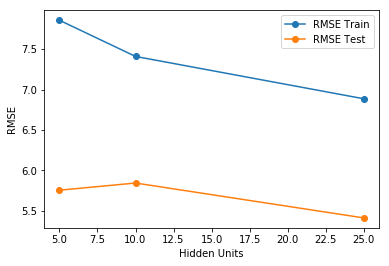

In [128]:
plt.ylabel('RMSE')
plt.xlabel('Hidden Units')

plt.plot(hidden_units_list, RMSE_trains, '-o', label='RMSE Train')
plt.plot(hidden_units_list, RMSE_tests, '-o', label='RMSE Test')
plt.legend(loc='best')

Looking at this data, it does look like there is some attraction between the two RMSE results with a Hidden Units at 10. There is a similar downward slope from Hidden Units values 10 to 25, leading it interesting to test for Higher Hidden Units values and perhaps seeing if there is some point where the slope of the resulting lines is narrower and leads to these meeting more.

## Grading

Download [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs445/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect execution score of 90 out of 90 points if your functions are defined correctly. The remaining 10 points will be based on the results you obtain from the energy data and on your discussions.

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

A different, but similar, grading script will be used to grade your checked-in notebook.  It will include additional tests.  You need not include code to test that the values passed in to your functions are the correct form.

In [130]:
%run -i A2grader.py

   Algorithm Epochs  Learning Rate Hidden Units Batch Size  RMSE Train  \
0        sgd     10          0.001            5          1  107.626910   
1       adam     10          0.001            5          1  171.573151   
2        sgd     10          0.010            5          1   96.153393   
3       adam     10          0.010            5          1  160.126544   
4        sgd    100          0.001            5          1   88.638844   
5       adam    100          0.001            5          1  159.633079   
6        sgd    100          0.010            5          1   99.992345   
7       adam    100          0.010            5          1  112.594797   
8        sgd     10          0.001            5         50  165.186084   
9       adam     10          0.001            5         50  172.524830   
10       sgd     10          0.010            5         50  123.531156   
11      adam     10          0.010            5         50  172.879599   
12       sgd    100          0.001    

# Extra Credit

Repeat the evaluation of parameter values for another data set of your choice.